# Spectral Analysis - Distance

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
from scipy.spatial.distance import hamming
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock
from scipy.spatial import minkowski_distance
import matplotlib.pyplot as plt
import networkx as nx
import hdbscan

Data will be stored in dictionaries

This allows for easy accessibility to any data point we use in the notebook.

In [2]:
data = {}
data['raw_data'] = {}
data['raw_data']['igt_orl'] = pd.read_csv('data/parameter_igt_orl.csv')
data['raw_data']['igt_pvl_delta'] = pd.read_csv('data/parameter_igt_pvl_delta.csv')
data['raw_data']['igt_vpp'] = pd.read_csv('data/parameters_igt_vpp.csv')
dataset_names = ['igt_orl', 'igt_pvl_delta', 'igt_vpp']

Calculating similarity between individuals

For each subject, we want to calculate their similarity to every other subject based on the data points given to us.

The first approach to do this was to calculate an absolute distance for each subject and each datapoint.  
We then build matrices with these distances.  

We use these adjacency matrices to create plots of the points and from here we can see if it is possible to cluster the data.

labels created
groups removed from data
building + standardising Adjacency matrices
igt_orl: A+


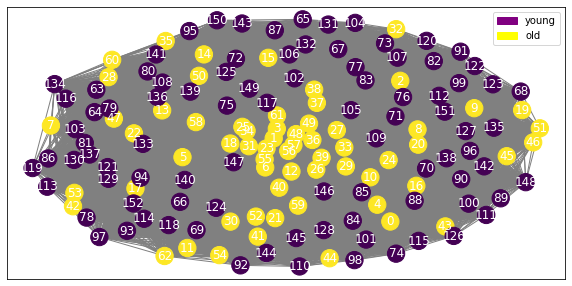

igt_orl: A-


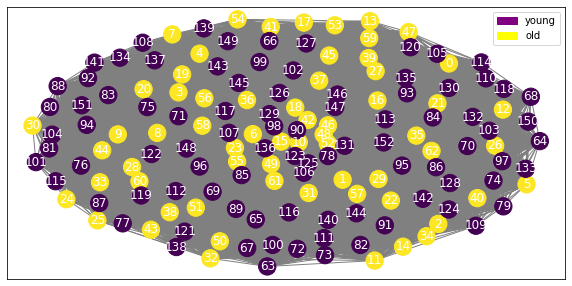

igt_orl: K


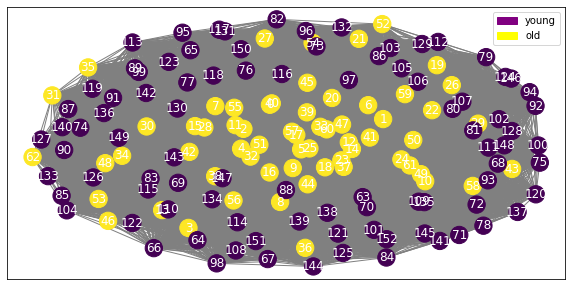

igt_orl: BetaF


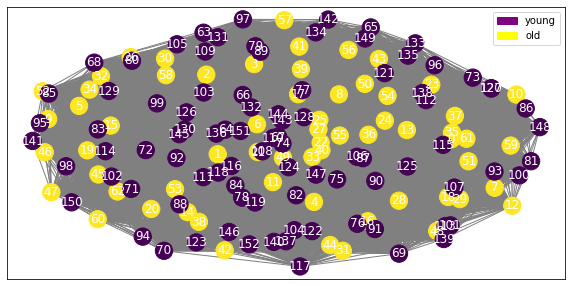

igt_orl: BetaP


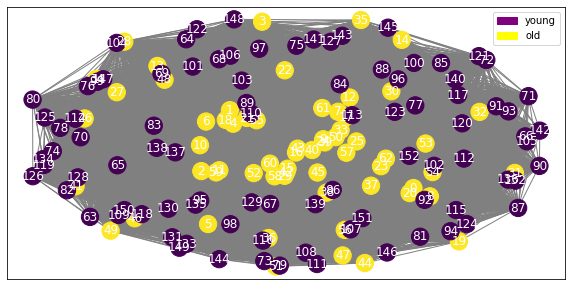

igt_orl: A+-A-


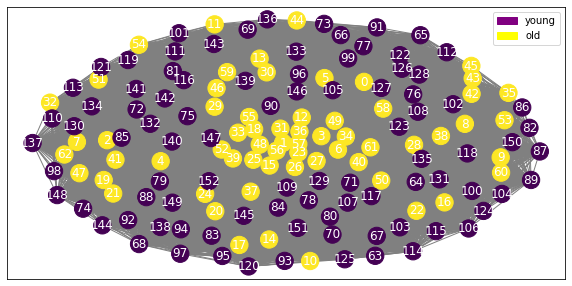

labels created
groups removed from data
building + standardising Adjacency matrices
igt_pvl_delta: LR


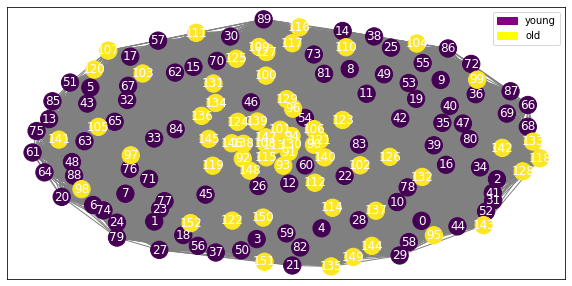

igt_pvl_delta: Outcome_Sens


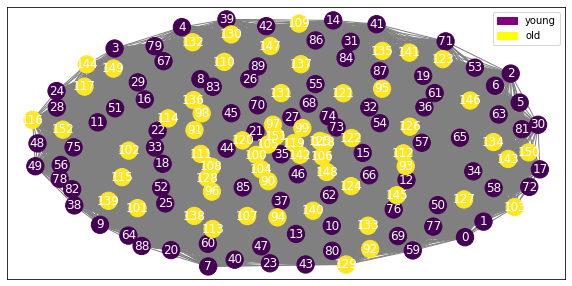

igt_pvl_delta: Response_cons


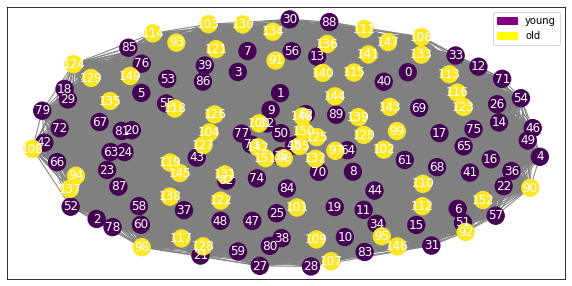

igt_pvl_delta: Loss_Aver


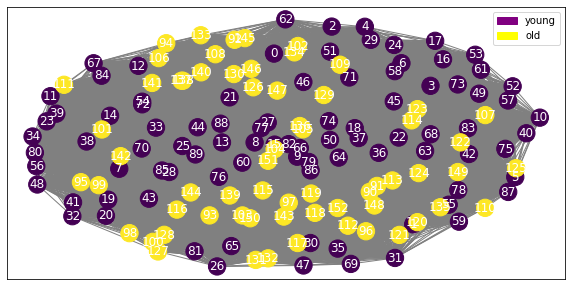

labels created
groups removed from data
building + standardising Adjacency matrices
igt_vpp: LR


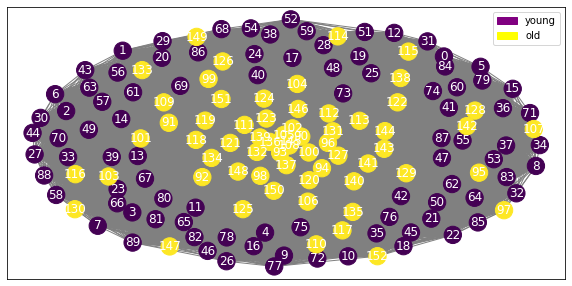

igt_vpp: Out_Sens


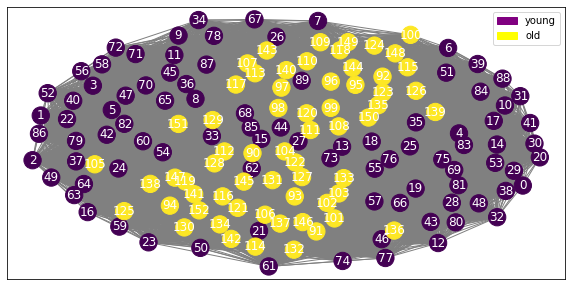

igt_vpp: Res_Cons


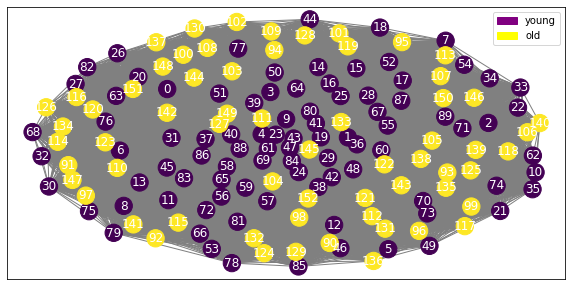

igt_vpp: Loss_Aver


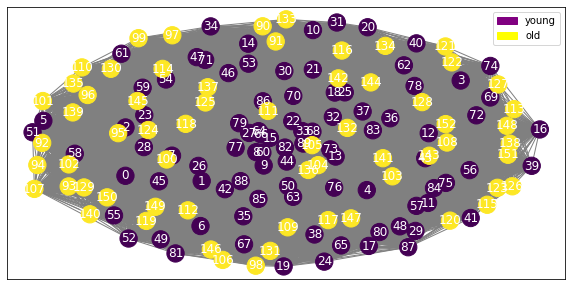

igt_vpp: Gain_Impa


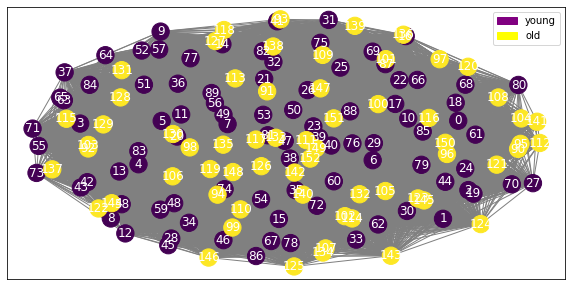

igt_vpp: Loss_Impa


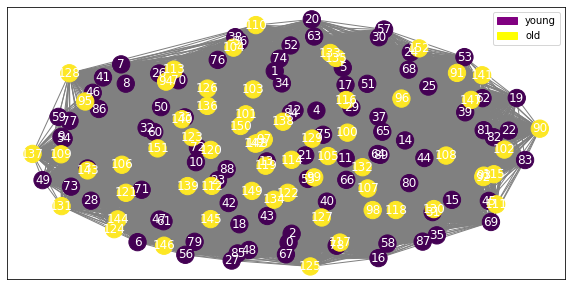

igt_vpp: Deca_Rate


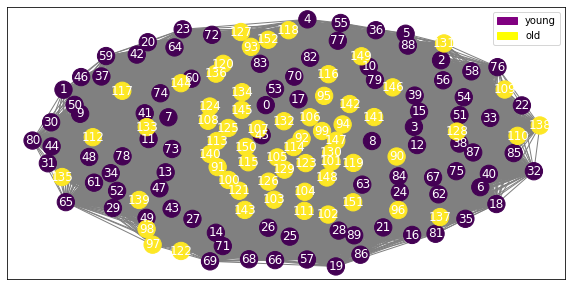

igt_vpp: RL_weight


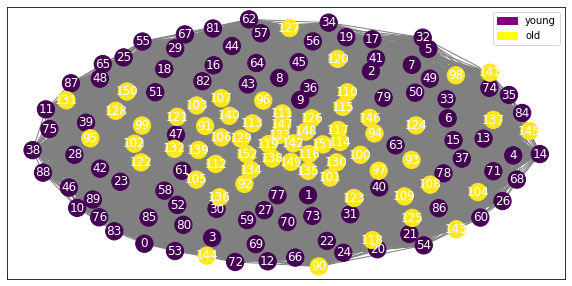

In [3]:
matrices = {}
# these are columns which we dont want to connect
bad_cols = ['group', 'SubID', 'subjID']
data['processed_data'] = {}
data['processed_data']['column_names'] = {}
data['processed_data']['by_column'] = {}
data['processed_data']['matrices'] = {}
data['processed_data']['matrices']['absolute_distance'] = {}
data['processed_data']['labels'] = {}
for dataset_name in data['raw_data']:
    # we create our young and old labels for each dataset
    labels = []
    if 'group' in data['raw_data'][dataset_name]:
        group_labels = data['raw_data'][dataset_name]['group']
    elif 'subjID' in data['raw_data'][dataset_name]:
        group_labels = data['raw_data'][dataset_name]['subjID']
    for label in group_labels:
        if label == 'young':
            labels.append(0)
        if label == 'old':
            labels.append(1)
    print("labels created")
    data['processed_data']['labels'][dataset_name] = labels
    dataset = data['raw_data'][dataset_name]
    data_points = list(dataset.columns)
    # get rid of bad columns - those which we don't want to use for clustering
    for col in bad_cols:
        if col in data_points:
            data_points.remove(col)
    print("groups removed from data")
    data['processed_data']['column_names'][dataset_name] = data_points
    data['processed_data']['by_column'][dataset_name] = {}
    data['processed_data']['matrices']['absolute_distance'][dataset_name] = {}
    #build distance matrices
    print("building + standardising Adjacency matrices")
    for data_point in data_points:
        data['processed_data']['by_column'][dataset_name][data_point] = dataset[data_point]
        data_column = dataset[data_point]
        data_matrix = np.zeros((153,153), dtype=float)
        for idx1, value1 in enumerate(data_column):
            for idx2, value2 in enumerate(data_column):
                if idx1 != idx2:
                    distance = abs(value1 - value2)
                    if data_matrix[idx1,idx2] == 0:
                        data_matrix[idx1,idx2] = distance
        assert(data_matrix[1,0] == data_matrix[0,1])
        assert(data_matrix[-1,-2] == data_matrix[-2, -1])
        # standardise the matrix
        scaler = StandardScaler()
        scaler.fit(data_matrix)
        data['processed_data']['matrices']['absolute_distance'][dataset_name][data_point] = data_matrix
        print(f"{dataset_name}: {data_point}")
        plt.figure(figsize=(10,5))
        B = nx.convert_matrix.from_numpy_array(data_matrix)
        nx.draw_networkx(B, with_labels=True, node_color=data['processed_data']['labels'][dataset_name], font_color='w', edge_color='grey')
        purp_patch = mpatches.Patch(color='purple', label='young')
        yellow_patch = mpatches.Patch(color='yellow', label='old')
        plt.legend(handles=[purp_patch, yellow_patch])
        plt.show()
        

Here we can see the distances for each point from other points under each feature given to us

Subjects which are closer to the centre of the network behave "normally" and those with the further distances
would be those subjects which behave most differently to others.

For the outcome representation dataset, we can see that generally older people behave most similarly.
There are some outliers however which skirt along the outsides of the graphs.

The younger nodes are spread evenly throughout the network.

Clustering at this level is quite difficult as the graph is so dense. 
HDBScan would probably work the best on this data as we can see circular patterns of nodes which wouldn't be effectively found using KMeans. However the data would have to be manipulated in some way as it is too dense. We will have to take another approach.

What happens when we layer these graphs on top of one another?

In [4]:
for dataset_name in data['raw_data']:
    master_matrix = np.zeros((153,153), dtype=float)
    for data_point in data['processed_data']['column_names'][dataset_name]:
        master_matrix = master_matrix + data['processed_data']['matrices']['absolute_distance'][dataset_name][data_point]
    data['processed_data']['matrices']['absolute_distance'][dataset_name]['master'] = master_matrix

igt_orl aggregate graph


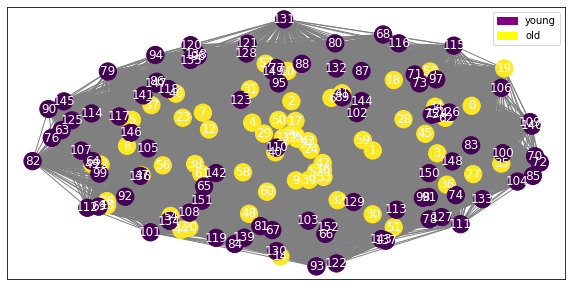

igt_pvl_delta aggregate graph


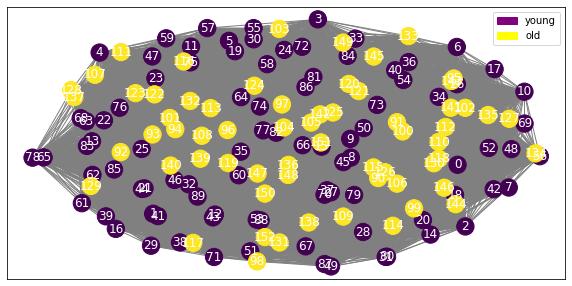

igt_vpp aggregate graph


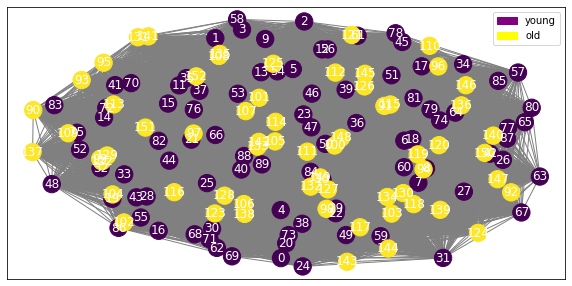

In [5]:
for dataset_name in data['raw_data']:
    matrix = data['processed_data']['matrices']['absolute_distance'][dataset_name]['master']
#     matrix = matrix * 2
    print(f"{dataset_name} aggregate graph")
    plt.figure(figsize=(10,5))
    B = nx.convert_matrix.from_numpy_array(matrix)
    nx.draw_networkx(B, with_labels=True, node_color=data['processed_data']['labels'][dataset_name], font_color='w', edge_color='grey')
    purp_patch = mpatches.Patch(color='purple', label='young')
    yellow_patch = mpatches.Patch(color='yellow', label='old')
    plt.legend(handles=[purp_patch, yellow_patch])
    plt.show()
    nx.write_graphml(B, f'{dataset_name}-master.graphml')

 We can see the data is beginning to pull apart a little, especially in the outcome representation learning model.
There seems to be a strong cluster of old people in the middle along with some slightly less obvious sub clusters surrounding 
the middle of the network.

The matrices can be multiplied and the relationships between nodes will be Amplified, it may give us a better insight into how each model behaves

Other distance measurements

Below we have tried using some other distance measurements

igt_orl hamming_distance


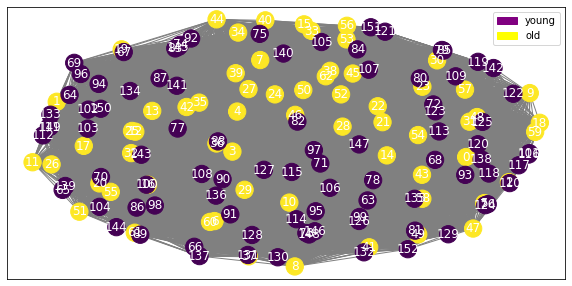

igt_orl euclidean_distance


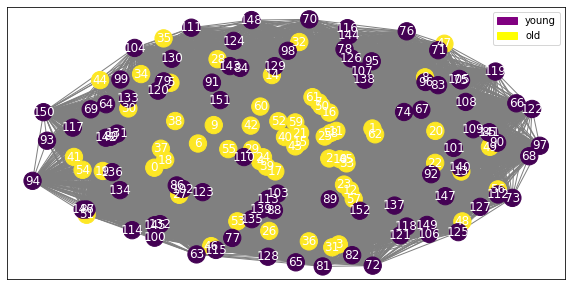

igt_orl cityblock_distance


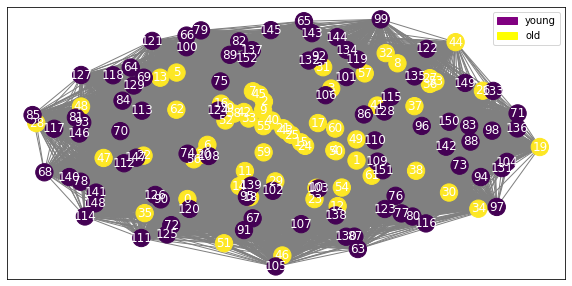

igt_orl minkowski_distance


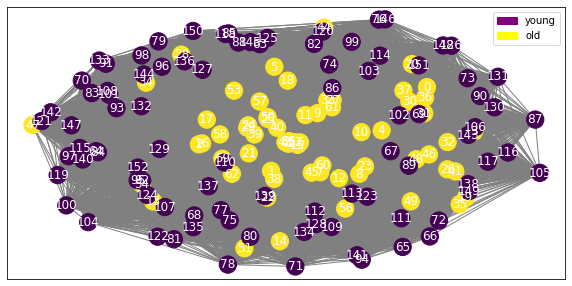

igt_pvl_delta hamming_distance


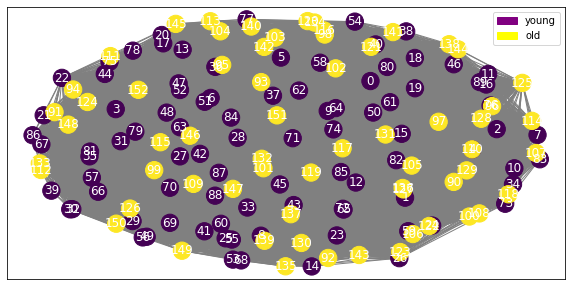

igt_pvl_delta euclidean_distance


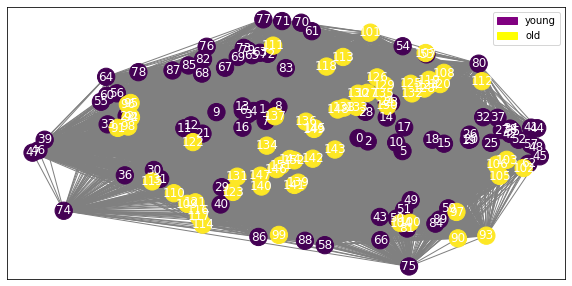

igt_pvl_delta cityblock_distance


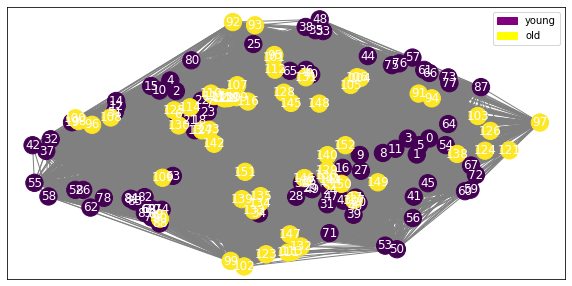

igt_pvl_delta minkowski_distance


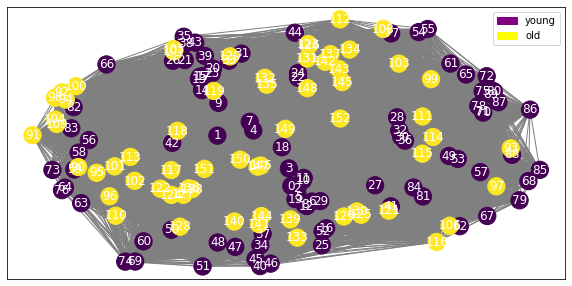

igt_vpp hamming_distance


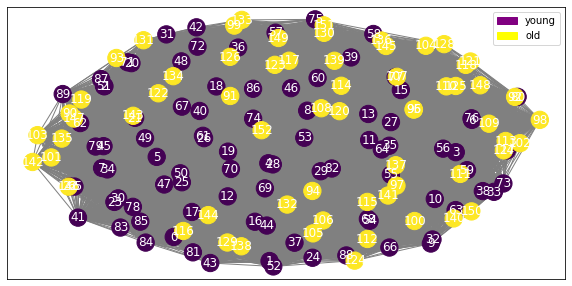

igt_vpp euclidean_distance


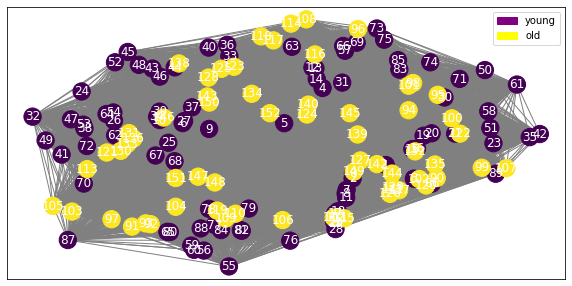

igt_vpp cityblock_distance


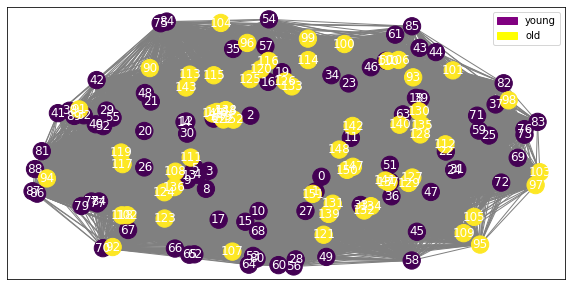

igt_vpp minkowski_distance


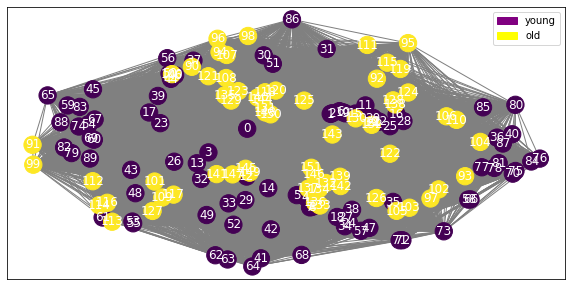

In [6]:
data['processed_data']['matrices']['hamming_distance'] = {}
data['processed_data']['matrices']['euclidean_distance'] = {}
data['processed_data']['matrices']['cityblock_distance'] = {}
data['processed_data']['matrices']['minkowski_distance'] = {}
for dataset_name in data['raw_data']:
    dataset = data['raw_data'][dataset_name]
    data['processed_data']['column_names'][dataset_name] = data_points
    data['processed_data']['matrices']['hamming_distance'][dataset_name] = np.zeros((153,153), dtype=float)
    data['processed_data']['matrices']['euclidean_distance'][dataset_name] = np.zeros((153,153), dtype=float)
    data['processed_data']['matrices']['cityblock_distance'][dataset_name] = np.zeros((153,153), dtype=float)
    data['processed_data']['matrices']['minkowski_distance'][dataset_name] = np.zeros((153,153), dtype=float)
    #build distance matrices
    for first_index in range(0,len(dataset)):
        for second_index in range(0,len(dataset)):
            if first_index != second_index:
                hamming_dist = hamming(dataset.iloc[first_index].tolist()[1:], dataset.iloc[second_index].tolist()[1:])
                euclidean_dist = euclidean(dataset.iloc[first_index].tolist()[1:], dataset.iloc[second_index].tolist()[1:])
                cityblock_dist = cityblock(dataset.iloc[first_index].tolist()[1:], dataset.iloc[second_index].tolist()[1:])
                minkowski_dist = minkowski_distance(dataset.iloc[first_index].tolist()[1:], dataset.iloc[second_index].tolist()[1:])
                data['processed_data']['matrices']['hamming_distance'][dataset_name][first_index,second_index] = hamming_dist
                data['processed_data']['matrices']['euclidean_distance'][dataset_name][second_index, first_index] = euclidean_dist
                data['processed_data']['matrices']['cityblock_distance'][dataset_name][second_index, first_index] = cityblock_dist
                data['processed_data']['matrices']['minkowski_distance'][dataset_name][second_index, first_index] = minkowski_dist
for dataset_name in data['raw_data']:
    for distance_measure in data['processed_data']['matrices']:
        if distance_measure != 'absolute_distance':
            print(f"{dataset_name} {distance_measure}")
            plt.figure(figsize=(10,5))
            matrix = data['processed_data']['matrices'][distance_measure][dataset_name]
            B = nx.convert_matrix.from_numpy_array(matrix)
            nx.draw_networkx(B, with_labels=True, node_color=data['processed_data']['labels'][dataset_name], font_color='w', edge_color='grey')
            purp_patch = mpatches.Patch(color='purple', label='young')
            yellow_patch = mpatches.Patch(color='yellow', label='old')
            plt.legend(handles=[purp_patch, yellow_patch])
            plt.show()